# Configure Preprocessing Params

This notebook should be used to set up preprocessing params.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## Imports

In [1]:
from pathlib import Path
import yaml
import pandas as pd
from microfilm.microplot import Microimage
import matplotlib.pyplot as plt

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_samples_df,
    create_micropanel,
)
from lib.preprocess.preprocess import extract_metadata, convert_to_array
from lib.preprocess.file_utils import get_sample_fps, get_tile_count_from_well

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for preprocessing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing.
- `ROOT_FP`: Path to root of Brieflow output directory.

*Note: Paths can be absolute or relative to where workflows are run from.*

In [2]:
CONFIG_FILE_PATH = "config/config.yml"
ROOT_FP = "brieflow_output/"

Path(CONFIG_FILE_PATH).parent.mkdir(parents=True, exist_ok=True)
Path(ROOT_FP).mkdir(parents=True, exist_ok=True)

## <font color='red'>SET PARAMETERS</font>

### Paths to dataframes with sample information
- `SBS_SAMPLES_DF_FP`/`PHENOTYPE_SAMPLES_DF_FP`: Path to dataframe where SBS/phenotype samples location and metadata will be stored.
- `SBS_COMBO_DF_FP`/`PHENOTYPE_COMBO_DF_FP`: Path to dataframe where SBS/phenotype sample metadata combinations will be stored.
- `SBS_IMAGES_DIR_FP`/`PHENOTYPE_IMAGES_DIR_FP`: Path to directories with SBS/phenotype sample ND2 files. Set to `None` to ignore SBS/phenotype testing in this notebook.

### Pattern configurations for metadata extraction

#### SBS Configuration
- `SBS_PATH_PATTERN`: Regex pattern to match directory structure of SBS files
- `SBS_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile", "cycle"` to extract SBS processing information
    - Optionally include `"z"` if your TIFF files are split by z-plane (e.g., `image_Z-0.tif`, `image_Z-1.tif`)
- `SBS_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.
- `SBS_N_Z_PLANES`: Number of z-planes per channel. Set to `None` for standard inputs, or an integer (e.g., `2`, `3`) if input files are split by z-plane. When specified, all z-planes for each channel will be stacked and max-projected to create a single 3D image (CYX).

#### Phenotype Configuration
- `PHENOTYPE_PATH_PATTERN`: Regex pattern to match directory structure of phenotype files  
- `PHENOTYPE_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile"` to extract phenotype processing information
    - Optionally include `"z"` if your TIFF files are split by z-plane (e.g., `image_Z-0.tif`, `image_Z-1.tif`)
- `PHENOTYPE_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.
- `PHENOTYPE_N_Z_PLANES`: Number of z-planes per channel. Set to `None` for standard inputs, or an integer (e.g., `2`, `3`) if input files are split by z-plane. When specified, all z-planes for each channel will be stacked and max-projected to create a single 3D image (CYX).

### Data Format and Organization

- `SBS_DATA_FORMAT`/`PHENOTYPE_DATA_FORMAT`: 
  - `"nd2"`: Nikon ND2 files (most common)
  - `"tiff"`: TIFF files (requires external metadata)
  
- `SBS_DATA_ORGANIZATION`/`PHENOTYPE_DATA_ORGANIZATION`:
  - `"tile"`: Each file contains ONE field of view (FOV/position)
    - Use when: Files like `plate1_well_A01_tile_001.nd2`, or `plate1_well_A01_tile_001.tiff`
  - `"well"`: Each file contains MULTIPLE fields of view
    - Use when: Files like `plate1_well_A01.nd2` with multiple positions inside

### Z-Dimension Handling (Optional)

**When to use**: If your microscopy data is exported with separate TIFF files per z-plane (e.g., `image_Z-0.tif`, `image_Z-1.tif`, `image_Z-2.tif`), set the `*_N_Z_PLANES` parameter to the number of z-planes per channel.

**How it works**:
1. Include `"z"` in your `*_PATH_METADATA` list and capture it in your regex pattern
2. Set `*_N_Z_PLANES` to the number of z-planes per channel (e.g., `2`, `3`, `5`)
3. During preprocessing, files will be grouped by channel, and for each channel:
   - All z-planes are stacked along the Z axis (creating CZYX format)
   - Max-projected along Z to create final CYX output
4. The output will be a standard 3D image (CYX) for downstream processing

**Example for z-split TIFFs with 2 z-planes per channel**:
```python
SBS_PATH_PATTERN = r"plate_(\d+)/c(\d+)/.*_Wells-([A-Z]\d+)_Points-(\d+)_Z-(\d+)\.tif"
SBS_PATH_METADATA = ["plate", "cycle", "well", "tile", "z"]
SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int, "z": int}
SBS_N_Z_PLANES = 2  # 2 z-planes per channel
SBS_CHANNEL_ORDER = ["DAPI", "GFP", "mCherry", "Cy5"]  # Must specify channel order for z-split files
```

*Notes:*
- Paths can be absolute or relative to where workflows are run from
- Each pattern should have the same number of capture groups as pieces of metadata listed
- Metadata lists should be ordered to match the capture groups in their corresponding regex pattern
- Numeric values (like cycle numbers) will automatically be converted to integers
- For Brieflow to run effectively, each sample file path should have an associated plate/well. For single plate/well screens, manually add a plate/well to the file path dataframe.
- Z-dimension is **optional** - most datasets won't have it. Only include `"z"` in metadata if your files actually contain z-plane identifiers.
- **IMPORTANT**: When using z-split files, you MUST specify `*_CHANNEL_ORDER` so files can be correctly grouped by channel before z-stacking.

In [3]:
# Paths to sample dataframes
SBS_SAMPLES_DF_FP = "config/sbs_samples.tsv"
PHENOTYPE_SAMPLES_DF_FP = "config/phenotype_samples.tsv"

# Paths to combination dataframes
SBS_COMBO_DF_FP = "config/sbs_combo.tsv"
PHENOTYPE_COMBO_DF_FP = "config/phenotype_combo.tsv"

# Paths to image directories
SBS_IMAGES_DIR_FP = Path("/mnt/data/uluru/input_sbs/")
PHENOTYPE_IMAGES_DIR_FP = Path("/mnt/data/uluru/input_ph/")

# SBS pattern configurations
# Pattern: plate_1/c1/0/A2_9_0_Fluorescence_561_nm_Ex_-_2.tiff
#          plate_1/c1/A2_9_0_Fluorescence_405_nm_Ex.tiff (without /0/)
#   - plate_1 = plate (capture digits after plate_)
#   - c1-c10 = cycle (capture digits after c)
#   - 0 = z-stack directory (optional, ignored)
#   - A2 = well
#   - 9 = tile
#   - 0 = z-slice (ignored, not captured)
#   - 561_nm_Ex_-_2 or 405_nm_Ex = channel (wavelength with optional _-_# suffix)
SBS_PATH_PATTERN = r"plate_(\d+)/c(\d+)(?:/\d+)?/([A-Z]\d+)_(\d+)_\d+_Fluorescence_(\d+_nm_Ex(?:_-_\d+)?)"
SBS_PATH_METADATA = ["plate", "cycle", "well", "tile", "channel"]
SBS_METADATA_ORDER_TYPE = {"plate": int, "cycle": int, "well": str, "tile": int, "channel": str}

# Phenotype pattern configurations
# Pattern: gs://scale1/uluru/input_ph/plate_1/round_1/0/A1_1000_0_Fluorescence_638_nm_-_Penta.tiff
#   - plate_1 = plate (capture digits after plate_)
#   - round_1 = round (capture digits after round_)
#   - 0 = z-stack directory (ignored, just part of path)
#   - A1 = well
#   - 1000 = tile
#   - 0 = z-slice
#   - 638_nm = channel (extract just the wavelength)
PHENOTYPE_PATH_PATTERN = r"plate_(\d+)/round_(\d+)/\d+/([A-Z]\d+)_(\d+)_(\d+)_Fluorescence_(\d+_nm)"
PHENOTYPE_PATH_METADATA = ["plate", "round", "well", "tile", "z", "channel"]
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "round": int, "well": str, "tile": int, "z": int, "channel": str}

# Data format and organization
SBS_DATA_FORMAT = "tiff" 
SBS_DATA_ORGANIZATION = "tile"
PHENOTYPE_DATA_FORMAT = "tiff"
PHENOTYPE_DATA_ORGANIZATION = "tile"

# Z-dimension handling (set to True if inputs are z-split TIFFs)
SBS_N_Z_PLANES = None
PHENOTYPE_N_Z_PLANES = 2

You must supply a working regex to the `SBS_PATH_PATTERN` and `PHENOTYPE_PATH_PATTERN` variables. If you don't have experience with regex, you can use the following LLM prompt to generate the patterns.

*Enter into a basic LLM chatbot*: 

Given ND2 filenames from your experiment, generate regex patterns to extract metadata. Return only the regex patterns with no explanation.

Example sbs filenames: **[ENTER YOUR EXAMPLE SBS FILES HERE WITH ANY UPSTREAM FOLDER STRUCTURE THAT IS RELEVANT TO THE METADATA]**

Example phenotype filenames: **[ENTER YOUR EXAMPLE PHENOTYPE FILES HERE WITH ANY UPSTREAM FOLDER STRUCTURE THAT IS RELEVANT TO THE METADATA]**

Required regex patterns (return these exact variable assignments):
```python
SBS_PATH_PATTERN = r"..."      # To match file path structure
PHENOTYPE_PATH_PATTERN = r"..." # To match file path structure
```

The patterns should extract:
1. SBS pattern:
     - Plate number (after "plate_")
     - Well ID (e.g., "A1", "B2")
     - Tile number (after "Points-")
     - Cycle number (after "/c")
     - **Optional**: Z-plane number if files are z-split (e.g., "Z-0", "Z-1")
2. PHENOTYPE pattern:
     - Plate number (after "plate_")
     - Well ID (e.g., "A1", "B2")
     - Tile number (after "Points-")
     - **Optional**: Z-plane number if files are z-split (e.g., "Z-0", "Z-1")

Also provide the corresponding metadata lists and variable types:
```python
SBS_PATH_METADATA = ["plate", "cycle", "well", "tile"]
PHENOTYPE_PATH_METADATA = ["plate", "well", "tile"]
SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int}
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int}

# If z-dimension is present in filenames, add "z" to metadata:
# SBS_PATH_METADATA = ["plate", "cycle", "well", "tile", "z"]
# SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int, "z": int}
# SBS_HAS_Z_DIMENSION = True
```

Example patterns for reference:
```python
# Standard patterns (no z-dimension)
SBS_PATH_PATTERN = r"plate_(\d+)/c(\d+)/.*_Wells-([A-Z]\d+)_Points-(\d+)__.*"
PHENOTYPE_PATH_PATTERN = r"P(\d+)_Pheno_20x_Wells-([A-Z]\d+)_Points-(\d+)__.*"

SBS_PATH_METADATA = ["plate", "cycle", "well", "tile"]
PHENOTYPE_PATH_METADATA = ["plate", "well", "tile"]

SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int}
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int}

# Example with z-dimension (z-split TIFFs)
# SBS_PATH_PATTERN = r"plate_(\d+)/c(\d+)/.*_Wells-([A-Z]\d+)_Points-(\d+)_Z-(\d+)\.tif"
# SBS_PATH_METADATA = ["plate", "cycle", "well", "tile", "z"]
# SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int, "z": int}
# SBS_HAS_Z_DIMENSION = True
```

## Create Sample DFs

In [4]:
# Create SBS samples DataFrame
sbs_samples = create_samples_df(
    SBS_IMAGES_DIR_FP, SBS_PATH_PATTERN, SBS_PATH_METADATA, SBS_METADATA_ORDER_TYPE
)
sbs_samples.to_csv(SBS_SAMPLES_DF_FP, sep="\t", index=False)
print("SBS samples:")
display(sbs_samples)

# Create SBS wildcard combos based on data organization
if SBS_DATA_ORGANIZATION == "tile":
    sbs_wildcard_combos = sbs_samples[SBS_PATH_METADATA].drop_duplicates().astype(str)
    sbs_wildcard_combos.to_csv(SBS_COMBO_DF_FP, sep="\t", index=False)
    print("SBS wildcard combos (tile organization):")
    display(sbs_wildcard_combos)
elif SBS_DATA_ORGANIZATION == "well" and len(sbs_samples) > 0:
    print("SBS: Detecting tile count for well organization...")
    # Get tile count from a sample well
    SBS_TILES = get_tile_count_from_well(
        sbs_samples,
        plate=sbs_samples["plate"].iloc[0],
        well=sbs_samples["well"].iloc[0],
        cycle=sbs_samples["cycle"].iloc[0] if "cycle" in sbs_samples.columns else None,
        verbose=True
    )
    print(f"Detected {SBS_TILES} tiles per well for SBS")
    
    # Generate combos with detected tile count
    base_combos = sbs_samples[SBS_PATH_METADATA].drop_duplicates().astype(str)
    tiles = [str(i) for i in range(SBS_TILES)]
    sbs_wildcard_combos = pd.DataFrame([
        {**row.to_dict(), "tile": tile}
        for _, row in base_combos.iterrows()
        for tile in tiles
    ])
    sbs_wildcard_combos.to_csv(SBS_COMBO_DF_FP, sep="\t", index=False)
    print("SBS wildcard combos (well organization):")
    display(sbs_wildcard_combos)

# Create phenotype samples DataFrame (always)
phenotype_samples = create_samples_df(
    PHENOTYPE_IMAGES_DIR_FP,
    PHENOTYPE_PATH_PATTERN,
    PHENOTYPE_PATH_METADATA,
    PHENOTYPE_METADATA_ORDER_TYPE,
)
phenotype_samples.to_csv(PHENOTYPE_SAMPLES_DF_FP, sep="\t", index=False)
print("Phenotype samples:")
display(phenotype_samples)

# Create phenotype wildcard combos based on data organization
if PHENOTYPE_DATA_ORGANIZATION == "tile":
    phenotype_wildcard_combos = phenotype_samples[PHENOTYPE_PATH_METADATA].drop_duplicates().astype(str)
    phenotype_wildcard_combos.to_csv(PHENOTYPE_COMBO_DF_FP, sep="\t", index=False)
    print("Phenotype wildcard combos (tile organization):")
    display(phenotype_wildcard_combos)
elif PHENOTYPE_DATA_ORGANIZATION == "well" and len(phenotype_samples) > 0:
    print("Phenotype: Detecting tile count for well organization...")
    # Get tile count from a sample well
    PHENOTYPE_TILES = get_tile_count_from_well(
        phenotype_samples,
        plate=phenotype_samples["plate"].iloc[0],
        well=phenotype_samples["well"].iloc[0],
        verbose=True
    )
    print(f"Detected {PHENOTYPE_TILES} tiles per well for phenotype")
    
    # Generate combos with detected tile count
    base_combos = phenotype_samples[PHENOTYPE_PATH_METADATA].drop_duplicates().astype(str)
    tiles = [str(i) for i in range(PHENOTYPE_TILES)]
    phenotype_wildcard_combos = pd.DataFrame([
        {**row.to_dict(), "tile": tile}
        for _, row in base_combos.iterrows()
        for tile in tiles
    ])
    phenotype_wildcard_combos.to_csv(PHENOTYPE_COMBO_DF_FP, sep="\t", index=False)
    print("Phenotype wildcard combos (well organization):")
    display(phenotype_wildcard_combos)

SBS samples:


,sample_fp,plate,cycle,well,tile,channel
0,/mnt/data/uluru/input_sbs/plate_1/c1/A1_0_0_Fl...,1,1,A1,0,405_nm_Ex
1,/mnt/data/uluru/input_sbs/plate_1/c1/A1_0_0_Fl...,1,1,A1,0,561_nm_Ex_-_1
2,/mnt/data/uluru/input_sbs/plate_1/c1/A1_0_0_Fl...,1,1,A1,0,561_nm_Ex_-_2
3,/mnt/data/uluru/input_sbs/plate_1/c1/A1_0_0_Fl...,1,1,A1,0,638_nm_Ex_-_1
4,/mnt/data/uluru/input_sbs/plate_1/c1/A1_0_0_Fl...,1,1,A1,0,638_nm_Ex_-_2
...,...,...,...,...,...,...
22795,/mnt/data/uluru/input_sbs/plate_1/c10/B3_75_0_...,1,10,B3,75,405_nm_Ex
22796,/mnt/data/uluru/input_sbs/plate_1/c10/B3_75_0_...,1,10,B3,75,561_nm_Ex_-_1
22797,/mnt/data/uluru/input_sbs/plate_1/c10/B3_75_0_...,1,10,B3,75,561_nm_Ex_-_2
22798,/mnt/data/uluru/input_sbs/plate_1/c10/B3_75_0_...,1,10,B3,75,638_nm_Ex_-_1


SBS wildcard combos (tile organization):


,plate,cycle,well,tile,channel
0,1,1,A1,0,405_nm_Ex
1,1,1,A1,0,561_nm_Ex_-_1
2,1,1,A1,0,561_nm_Ex_-_2
3,1,1,A1,0,638_nm_Ex_-_1
4,1,1,A1,0,638_nm_Ex_-_2
...,...,...,...,...,...
22795,1,10,B3,75,405_nm_Ex
22796,1,10,B3,75,561_nm_Ex_-_1
22797,1,10,B3,75,561_nm_Ex_-_2
22798,1,10,B3,75,638_nm_Ex_-_1


Phenotype samples:


,sample_fp,plate,round,well,tile,z,channel
0,/mnt/data/uluru/input_ph/plate_1/round_1/0/A1_...,1,1,A1,0,0,405_nm
1,/mnt/data/uluru/input_ph/plate_1/round_1/0/A1_...,1,1,A1,0,0,488_nm
2,/mnt/data/uluru/input_ph/plate_1/round_1/0/A1_...,1,1,A1,0,0,561_nm
3,/mnt/data/uluru/input_ph/plate_1/round_1/0/A1_...,1,1,A1,0,0,638_nm
4,/mnt/data/uluru/input_ph/plate_1/round_1/0/A1_...,1,1,A1,0,1,405_nm
...,...,...,...,...,...,...,...
162523,/mnt/data/uluru/input_ph/plate_2/round_1/0/B3_...,2,1,B3,1692,0,638_nm
162524,/mnt/data/uluru/input_ph/plate_2/round_1/0/B3_...,2,1,B3,1692,1,405_nm
162525,/mnt/data/uluru/input_ph/plate_2/round_1/0/B3_...,2,1,B3,1692,1,488_nm
162526,/mnt/data/uluru/input_ph/plate_2/round_1/0/B3_...,2,1,B3,1692,1,561_nm


Phenotype wildcard combos (tile organization):


,plate,round,well,tile,z,channel
0,1,1,A1,0,0,405_nm
1,1,1,A1,0,0,488_nm
2,1,1,A1,0,0,561_nm
3,1,1,A1,0,0,638_nm
4,1,1,A1,0,1,405_nm
...,...,...,...,...,...,...
162523,2,1,B3,1692,0,638_nm
162524,2,1,B3,1692,1,405_nm
162525,2,1,B3,1692,1,488_nm
162526,2,1,B3,1692,1,561_nm


## <font color='red'>SET PARAMETERS</font>

### Metadata Source Configuration

- `SBS_METADATA_*`/`PHENOTYPE_METADATA_*`: Configuration for external metadata files containing positional and imaging metadata.
 - **For TIFF files**: Usually required (e.g., `coordinates.csv`, `metadata.tsv`)
 - **For ND2 files**: Usually set directories to `None` (metadata extracted from ND2 headers)

**Metadata File Organization:**
- `*_METADATA_IMAGES_DIR_FP`: Base directory containing metadata files
- `*_METADATA_PATH_PATTERN`: Regex pattern to find metadata files
- `*_METADATA_PATH_METADATA`: Metadata to extract from file paths
- `*_METADATA_SAMPLES_DF_FP`: Where to save the metadata file inventory

In [5]:
# Set metadata extraction parameters
SBS_METADATA_IMAGES_DIR_FP = Path("/mnt/data/uluru/input_sbs/")
SBS_METADATA_PATH_PATTERN = r"plate_(\d+)/c(\d+)(?:/\d+)?/coordinates\.csv"
SBS_METADATA_PATH_METADATA = ["plate", "cycle"]
SBS_METADATA_ORDER_TYPE = {"plate": int, "cycle": int}
SBS_METADATA_SAMPLES_DF_FP = "config/sbs_metadata_samples.tsv"

# Phenotype metadata configuration (coordinates.csv file)
# Path: gs://scale1/uluru/input_ph/plate_1/round_1/0/coordinates.csv
PHENOTYPE_METADATA_IMAGES_DIR_FP = Path("/mnt/data/uluru/input_ph/")
PHENOTYPE_METADATA_PATH_PATTERN = r"plate_(\d+)/round_(\d+)/\d+/coordinates\.csv"
PHENOTYPE_METADATA_PATH_METADATA = ["plate", "round"]
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "round": int}
PHENOTYPE_METADATA_SAMPLES_DF_FP = "config/phenotype_metadata_samples.tsv"

In [6]:
# # Generate SBS metadata samples table
if SBS_METADATA_IMAGES_DIR_FP is not None:
    print("Generating SBS metadata file inventory...")
    sbs_metadata_samples = create_samples_df(
        SBS_METADATA_IMAGES_DIR_FP, 
        SBS_METADATA_PATH_PATTERN, 
        SBS_METADATA_PATH_METADATA, 
        SBS_METADATA_ORDER_TYPE
    )
    sbs_metadata_samples.to_csv(SBS_METADATA_SAMPLES_DF_FP, sep="\t", index=False)
    print("SBS metadata files found:")
    display(sbs_metadata_samples)
else:
    print("SBS: No external metadata files - will extract from image files")
    sbs_metadata_samples = pd.DataFrame()

# Generate phenotype metadata samples table
if PHENOTYPE_METADATA_IMAGES_DIR_FP is not None:
    print("\nGenerating phenotype metadata file inventory...")
    phenotype_metadata_samples = create_samples_df(
        PHENOTYPE_METADATA_IMAGES_DIR_FP,
        PHENOTYPE_METADATA_PATH_PATTERN,
        PHENOTYPE_METADATA_PATH_METADATA,
        PHENOTYPE_METADATA_ORDER_TYPE
    )
    phenotype_metadata_samples.to_csv(PHENOTYPE_METADATA_SAMPLES_DF_FP, sep="\t", index=False)
    print("Phenotype metadata files found:")
    display(phenotype_metadata_samples)
else:
    print("Phenotype: No external metadata files - will extract from ND2 files")
    phenotype_metadata_samples = pd.DataFrame()

Generating SBS metadata file inventory...
SBS metadata files found:


,sample_fp,plate,cycle
0,/mnt/data/uluru/input_sbs/plate_1/c1/coordinat...,1,1
1,/mnt/data/uluru/input_sbs/plate_1/c2/coordinat...,1,2
2,/mnt/data/uluru/input_sbs/plate_1/c3/coordinat...,1,3
3,/mnt/data/uluru/input_sbs/plate_1/c4/coordinat...,1,4
4,/mnt/data/uluru/input_sbs/plate_1/c5/coordinat...,1,5
5,/mnt/data/uluru/input_sbs/plate_1/c6/coordinat...,1,6
6,/mnt/data/uluru/input_sbs/plate_1/c7/coordinat...,1,7
7,/mnt/data/uluru/input_sbs/plate_1/c8/coordinat...,1,8
8,/mnt/data/uluru/input_sbs/plate_1/c9/coordinat...,1,9
9,/mnt/data/uluru/input_sbs/plate_1/c10/coordina...,1,10



Generating phenotype metadata file inventory...
Phenotype metadata files found:


,sample_fp,plate,round
0,/mnt/data/uluru/input_ph/plate_1/round_1/0/coo...,1,1
1,/mnt/data/uluru/input_ph/plate_2/round_1/0/coo...,2,1


## Test Metadata Extraction

In [7]:
if len(sbs_samples) > 0:
    print("Testing SBS metadata extraction...")
    
    # Get metadata file for this specific sample
    if len(sbs_metadata_samples) > 0:
        # Find matching metadata file
        test_metadata_file = get_sample_fps(
            sbs_metadata_samples,
            plate=sbs_samples["plate"].iloc[0],
            cycle=sbs_samples["cycle"].iloc[0] if "cycle" in sbs_samples.columns else None
        )
        print(f"Using metadata file: {test_metadata_file}")
    else:
        test_metadata_file = None  
        print("No metadata files - extracting from image files")
    
    # Extract metadata using unified function
    test_sbs_metadata = extract_metadata(
        sbs_samples["sample_fp"].iloc[0],
        plate=sbs_samples["plate"].iloc[0],
        well=sbs_samples["well"].iloc[0],
        tile=sbs_samples["tile"].iloc[0] if "tile" in sbs_samples.columns else 0,
        cycle=sbs_samples.get("cycle", [None]).iloc[0],
        data_format=SBS_DATA_FORMAT,
        data_organization=SBS_DATA_ORGANIZATION,
        metadata_file_path=test_metadata_file,
        verbose=True
    )
    print("SBS test metadata:")
    display(test_sbs_metadata)

# Test phenotype metadata extraction  
if len(phenotype_samples) > 0:
    print("\nTesting phenotype metadata extraction...")
    
    # Get metadata file for this specific sample (if any)
    if len(phenotype_metadata_samples) > 0:
        # Find matching metadata file
        test_metadata_file = get_sample_fps(
            phenotype_metadata_samples,
            plate=phenotype_samples["plate"].iloc[0],
            round_order=phenotype_samples["round"].iloc[0] if "round" in phenotype_samples.columns else None
        )
        print(f"Using metadata file: {test_metadata_file}")
    else:
        test_metadata_file = None 
        print("No metadata files - extracting from ND2 files")
    
    # Extract metadata using unified function
    test_phenotype_metadata = extract_metadata(
        phenotype_samples["sample_fp"].iloc[0],
        plate=phenotype_samples["plate"].iloc[0],
        well=phenotype_samples["well"].iloc[0],
        tile=phenotype_samples["tile"].iloc[0] if "tile" in phenotype_samples.columns else 0,
        round=phenotype_samples["round"].iloc[0] if "round" in phenotype_samples.columns else None,
        data_format=PHENOTYPE_DATA_FORMAT,
        data_organization=PHENOTYPE_DATA_ORGANIZATION,
        metadata_file_path=test_metadata_file,
        verbose=True
    )
    print("Phenotype test metadata:")
    display(test_phenotype_metadata)

Testing SBS metadata extraction...
Using metadata file: /mnt/data/uluru/input_sbs/plate_1/c1/coordinates.csv
Reading metadata from: /mnt/data/uluru/input_sbs/plate_1/c1/coordinates.csv
Columns: ['region', 'fov', 'z_level', 'x (mm)', 'y (mm)', 'z (um)', 'time']
Converted 456 rows of metadata
SBS test metadata:


,plate,well,tile,filename,x_pos,y_pos,z_pos,pfs_offset,channels,pixel_size_x,pixel_size_y,cycle
0,1,A1,0,/mnt/data/uluru/input_sbs/plate_1/c1/A1_0_0_Fl...,16604.75449,6617.890221,None,None,None,None,None,1
1,1,A1,1,/mnt/data/uluru/input_sbs/plate_1/c1/A1_0_0_Fl...,20130.88249,6617.890221,None,None,None,None,None,1
2,1,A1,2,/mnt/data/uluru/input_sbs/plate_1/c1/A1_0_0_Fl...,23657.01049,6617.890221,None,None,None,None,None,1
3,1,A1,3,/mnt/data/uluru/input_sbs/plate_1/c1/A1_0_0_Fl...,27183.13849,6617.890221,None,None,None,None,None,1
4,1,A1,4,/mnt/data/uluru/input_sbs/plate_1/c1/A1_0_0_Fl...,13078.62649,10144.018220,None,None,None,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...
451,1,B3,71,/mnt/data/uluru/input_sbs/plate_1/c1/A1_0_0_Fl...,109108.87500,74026.712500,None,None,None,None,None,1
452,1,B3,72,/mnt/data/uluru/input_sbs/plate_1/c1/A1_0_0_Fl...,95004.73125,77553.343750,None,None,None,None,None,1
453,1,B3,73,/mnt/data/uluru/input_sbs/plate_1/c1/A1_0_0_Fl...,98530.56875,77553.343750,None,None,None,None,None,1
454,1,B3,74,/mnt/data/uluru/input_sbs/plate_1/c1/A1_0_0_Fl...,102057.20000,77553.343750,None,None,None,None,None,1



Testing phenotype metadata extraction...
Using metadata file: /mnt/data/uluru/input_ph/plate_1/round_1/0/coordinates.csv
Reading metadata from: /mnt/data/uluru/input_ph/plate_1/round_1/0/coordinates.csv
Columns: ['region', 'fov', 'z_level', 'x (mm)', 'y (mm)', 'z (um)', 'time']
Converted 20316 rows of metadata
Phenotype test metadata:


,plate,well,tile,filename,x_pos,y_pos,z_pos,pfs_offset,channels,pixel_size_x,pixel_size_y,round
0,1,A1,0,/mnt/data/uluru/input_ph/plate_1/round_1/0/A1_...,19778.66250,6265.06875,3502.68750,None,None,None,None,1
1,1,A1,0,/mnt/data/uluru/input_ph/plate_1/round_1/0/A1_...,19778.66250,6265.06875,3504.75000,None,None,None,None,1
2,1,A1,1,/mnt/data/uluru/input_ph/plate_1/round_1/0/A1_...,20483.51250,6265.06875,3502.78125,None,None,None,None,1
3,1,A1,1,/mnt/data/uluru/input_ph/plate_1/round_1/0/A1_...,20483.51250,6265.06875,3504.84375,None,None,None,None,1
4,1,A1,2,/mnt/data/uluru/input_ph/plate_1/round_1/0/A1_...,21188.36250,6265.06875,3502.59375,None,None,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...
20311,1,B3,1690,/mnt/data/uluru/input_ph/plate_1/round_1/0/A1_...,100999.13125,77905.76875,3556.78125,None,None,None,None,1
20312,1,B3,1691,/mnt/data/uluru/input_ph/plate_1/round_1/0/A1_...,101704.77500,77905.76875,3554.53125,None,None,None,None,1
20313,1,B3,1691,/mnt/data/uluru/input_ph/plate_1/round_1/0/A1_...,101704.77500,77905.76875,3556.59375,None,None,None,None,1
20314,1,B3,1692,/mnt/data/uluru/input_ph/plate_1/round_1/0/A1_...,102409.62500,77905.76875,3555.00000,None,None,None,None,1


## <font color='red'>SET PARAMETERS</font>

### Image conversion

- `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER`: Manually set channel order _if ND2 images are acquired as single channels, or there are multiple files for each tile (e.g. multiple rounds of phenotype images). Should be `None` if multichannel image files are acquired. The extracted channel names must match the values that will be displayed in the samples DataFrame channel column (e.g., `["DAPI", "GFP", "CY3", "CY5", "AF750"]`).
- `PHENOTYPE_ROUND_ORDER`: List of round numbers specifying the order in which to process phenotype image rounds. Should be `None` if there is only one round of phenotyping. For multiple rounds, specify the round numbers in the desired order (e.g., `[1, 2, 3]`). The round numbers must match the values in the samples DataFrame round column.

**Note** For single-channel files, each file must contain a channel identifier that your regex can extract. For multichannel files, set the channel patterns to `None`. Metadata extraction is only performed on the first channel dimension for each tile. Please ensure the Dapi channel is displayed first!

- `SBS_CHANNEL_ORDER_FLIP`/`PHENOTYPE_CHANNEL_ORDER_FLIP`: Whether or not to flip channel order when converting ND2->tiff. Should be `False` if channels are in a standard order (with Dapi first), or `True` if channels are reversed. This will only occur for multichannel ND2 files, for each individual ND2 file. Setting the channel order for single channel files is done by setting `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER` previously.

**Note** Channel order can be checked with the test conversions below. Please ensure the Dapi channel is displayed first!

In [8]:
SBS_CHANNEL_ORDER = ["405_nm_Ex", "561_nm_Ex_-_1", "561_nm_Ex_-_2", "638_nm_Ex_-_1", "638_nm_Ex_-_2"]
PHENOTYPE_CHANNEL_ORDER = ["405_nm", "488_nm", "561_nm", "638_nm"]
PHENOTYPE_ROUND_ORDER = [1]
SBS_CHANNEL_ORDER_FLIP = False
PHENOTYPE_CHANNEL_ORDER_FLIP = False

## Test Image Conversion

### Test SBS conversion

Testing SBS image conversion...
Processing TIFF file 1/5: /mnt/data/uluru/input_sbs/plate_1/c1/A1_0_0_Fluorescence_405_nm_Ex.tiff
  TIFF array shape: (1, 4168, 4168)
Processing TIFF file 2/5: /mnt/data/uluru/input_sbs/plate_1/c1/A1_0_0_Fluorescence_561_nm_Ex_-_1.tiff
  TIFF array shape: (1, 4168, 4168)
Processing TIFF file 3/5: /mnt/data/uluru/input_sbs/plate_1/c1/A1_0_0_Fluorescence_561_nm_Ex_-_2.tiff
  TIFF array shape: (1, 4168, 4168)
Processing TIFF file 4/5: /mnt/data/uluru/input_sbs/plate_1/c1/A1_0_0_Fluorescence_638_nm_Ex_-_1.tiff
  TIFF array shape: (1, 4168, 4168)
Processing TIFF file 5/5: /mnt/data/uluru/input_sbs/plate_1/c1/A1_0_0_Fluorescence_638_nm_Ex_-_2.tiff
  TIFF array shape: (1, 4168, 4168)
Concatenated 5 files along channel axis: (5, 4168, 4168)
SBS converted image shape: (5, 4168, 4168)


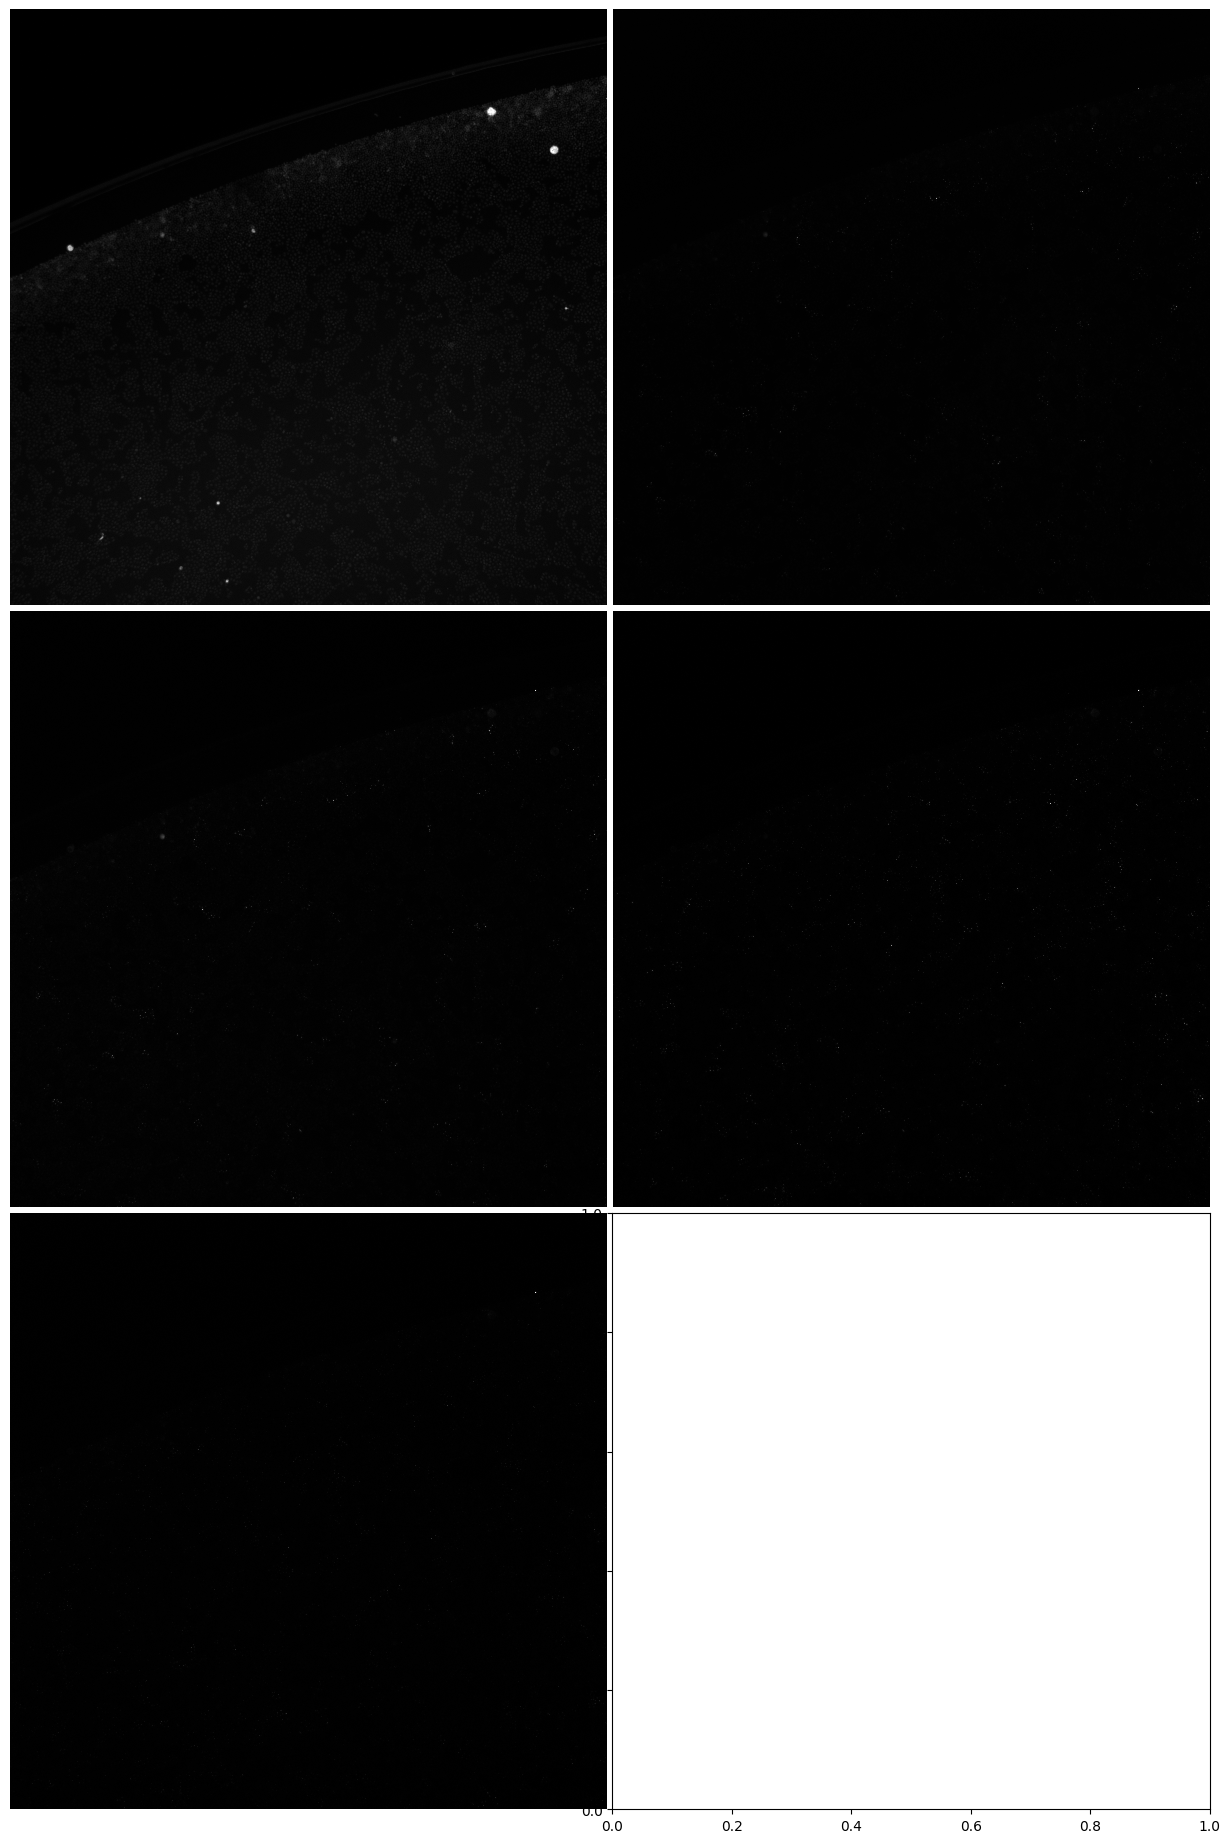

In [9]:
if len(sbs_samples) > 0:
    print("Testing SBS image conversion...")
    
    # Get sample files based on data organization
    if SBS_DATA_ORGANIZATION == "tile":
        sbs_sample_files = get_sample_fps(
            sbs_samples,
            plate=sbs_samples["plate"].iloc[0],
            well=sbs_samples["well"].iloc[0],
            tile=sbs_samples["tile"].iloc[0] if "tile" in sbs_samples.columns else 0,
            cycle=sbs_samples["cycle"].iloc[0] if "cycle" in sbs_samples.columns else None,
            channel_order=SBS_CHANNEL_ORDER,
        )
    else:  # well organization
        sbs_sample_files = get_sample_fps(
            sbs_samples,
            plate=sbs_samples["plate"].iloc[0],
            well=sbs_samples["well"].iloc[0],
            cycle=sbs_samples["cycle"].iloc[0] if "cycle" in sbs_samples.columns else None,
            channel_order=SBS_CHANNEL_ORDER,
        )
        
    # Convert using unified function
    sbs_image = convert_to_array(
        sbs_sample_files,
        data_format=SBS_DATA_FORMAT,
        data_organization=SBS_DATA_ORGANIZATION,
        position=0 if SBS_DATA_ORGANIZATION == "well" else None,
        channel_order_flip=SBS_CHANNEL_ORDER_FLIP,
        n_z_planes=SBS_N_Z_PLANES,
        verbose=True
    )
    
    print(f"SBS converted image shape: {sbs_image.shape}")
    
    # Display images
    sbs_microimages = [Microimage(image) for image in sbs_image]
    sbs_panel = create_micropanel(sbs_microimages, add_channel_label=False)
    plt.title("SBS Test Conversion")
    plt.show()

### Test phenotype conversion

Testing phenotype image conversion...
Z-aware stacking: 4 channels × 2 z-planes = 8 files
Processing TIFF file 1/8: /mnt/data/uluru/input_ph/plate_1/round_1/0/A1_0_0_Fluorescence_405_nm_-_Penta.tiff
  TIFF array shape: (1, 2084, 2084)
Processing TIFF file 2/8: /mnt/data/uluru/input_ph/plate_1/round_1/0/A1_0_1_Fluorescence_405_nm_-_Penta.tiff
  TIFF array shape: (1, 2084, 2084)
Processing TIFF file 3/8: /mnt/data/uluru/input_ph/plate_1/round_1/0/A1_0_0_Fluorescence_488_nm_-_1.tiff
  TIFF array shape: (1, 2084, 2084)
Processing TIFF file 4/8: /mnt/data/uluru/input_ph/plate_1/round_1/0/A1_0_1_Fluorescence_488_nm_-_1.tiff
  TIFF array shape: (1, 2084, 2084)
Processing TIFF file 5/8: /mnt/data/uluru/input_ph/plate_1/round_1/0/A1_0_0_Fluorescence_561_nm_-_Penta.tiff
  TIFF array shape: (1, 2084, 2084)
Processing TIFF file 6/8: /mnt/data/uluru/input_ph/plate_1/round_1/0/A1_0_1_Fluorescence_561_nm_-_Penta.tiff
  TIFF array shape: (1, 2084, 2084)
Processing TIFF file 7/8: /mnt/data/uluru/input_

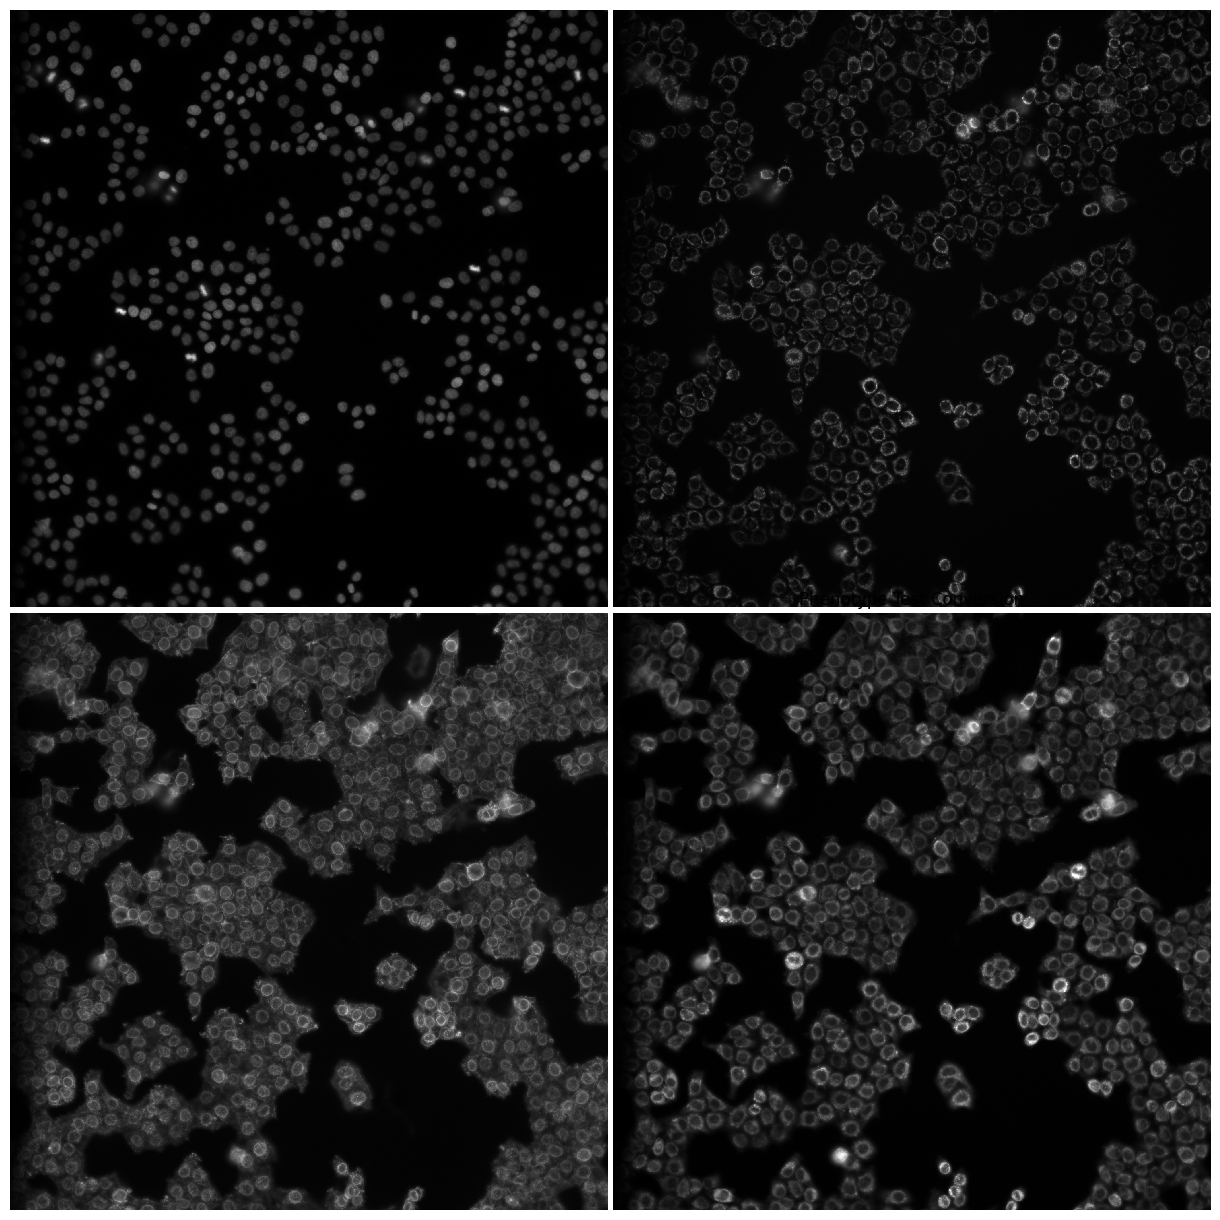

In [10]:
if len(phenotype_samples) > 0:
    print("Testing phenotype image conversion...")
    
    # Get sample files based on data organization
    if PHENOTYPE_DATA_ORGANIZATION == "tile":
        phenotype_sample_files = get_sample_fps(
            phenotype_samples,
            plate=phenotype_samples["plate"].iloc[0],
            well=phenotype_samples["well"].iloc[0],
            tile=phenotype_samples["tile"].iloc[0] if "tile" in phenotype_samples.columns else 0,
            round_order=PHENOTYPE_ROUND_ORDER,
            channel_order=PHENOTYPE_CHANNEL_ORDER,
        )
    else:  # well organization
        phenotype_sample_files = get_sample_fps(
            phenotype_samples,
            plate=phenotype_samples["plate"].iloc[0],
            well=phenotype_samples["well"].iloc[0],
            round_order=PHENOTYPE_ROUND_ORDER,
            channel_order=PHENOTYPE_CHANNEL_ORDER,
        )
      
    # Convert using unified function
    phenotype_image = convert_to_array(
        phenotype_sample_files,
        data_format=PHENOTYPE_DATA_FORMAT,
        data_organization=PHENOTYPE_DATA_ORGANIZATION,
        position=0 if PHENOTYPE_DATA_ORGANIZATION == "well" else None,
        channel_order_flip=PHENOTYPE_CHANNEL_ORDER_FLIP,
        n_z_planes=PHENOTYPE_N_Z_PLANES,
        verbose=True
    )
    
    print(f"Phenotype converted image shape: {phenotype_image.shape}")
    
    # Display images
    phenotype_microimages = [Microimage(image) for image in phenotype_image]
    phenotype_panel = create_micropanel(phenotype_microimages, add_channel_label=False)
    plt.title("Phenotype Test Conversion")
    plt.show()

## <font color='red'>SET PARAMETERS</font>

### Calculate illumination correction field

- `SAMPLE_FRACTION`: Controls what percentage of images to use when calculating the illumination correction field (0.0-1.0). Using a smaller fraction (e.g., 0.2 = 20%) speeds up processing by randomly sampling only a subset of your images. Default is 1.0 (use all images). For reliable results, ensure your sample contains enough images to accurately represent illumination variation.

In [11]:
SAMPLE_FRACTION = 0.05

## Create config file with params

In [12]:
# Create empty config variable
config = {}

# Add all section
config["all"] = {
    "root_fp": ROOT_FP,
}

# Add preprocess section
config["preprocess"] = {
    # File paths
    "sbs_samples_fp": SBS_SAMPLES_DF_FP,
    "sbs_combo_fp": SBS_COMBO_DF_FP,
    "phenotype_samples_fp": PHENOTYPE_SAMPLES_DF_FP,
    "phenotype_combo_fp": PHENOTYPE_COMBO_DF_FP,
    
    # SBS configuration
    "sbs_data_format": SBS_DATA_FORMAT,
    "sbs_data_organization": SBS_DATA_ORGANIZATION,
    "sbs_channel_order": SBS_CHANNEL_ORDER,
    "sbs_channel_order_flip": SBS_CHANNEL_ORDER_FLIP,
    "sbs_n_z_planes": SBS_N_Z_PLANES,
    "sbs_metadata_samples_df_fp": SBS_METADATA_SAMPLES_DF_FP,
    
    # Phenotype configuration
    "phenotype_data_format": PHENOTYPE_DATA_FORMAT,
    "phenotype_data_organization": PHENOTYPE_DATA_ORGANIZATION,
    "phenotype_channel_order": PHENOTYPE_CHANNEL_ORDER,
    "phenotype_channel_order_flip": PHENOTYPE_CHANNEL_ORDER_FLIP,
    "phenotype_round_order": PHENOTYPE_ROUND_ORDER,
    "phenotype_n_z_planes": PHENOTYPE_N_Z_PLANES,
    "phenotype_metadata_samples_df_fp": PHENOTYPE_METADATA_SAMPLES_DF_FP,

    # Processing parameters
    "sample_fraction": SAMPLE_FRACTION,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False, sort_keys=False)